In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
from dataio.genetics import GeneticDataset, GeneticOneHot
import pandas as pd
import torch
from model.utils import decode_onehot
import matplotlib.pyplot as plt

In [60]:
TRAIN_PATH = "datasets/genetics/small_diptera_family-train.tsv"
VALIDATION_PATH = "datasets/genetics/small_diptera_family-validation.tsv"
TAXONOMY_NAME = "family"
PROTOTYPE_PATH = "saved_models/genetics/prototype_saving_test_images/epoch-1/genetic-string.csv"
WEIGHT_PATH = "saved_models/genetics/prototype_saving_test_images/10_push_weights.pth"
PROTOTYPE_COUNT = 10

In [61]:
codon_map_a = {
    "Phe": ["TTT", "TTC"],
    "Leu": ["TTA", "TTG", "CTT", "CTC", "CTA", "CTG"],
    "Ile": ["ATT", "ATC", "ATA"],
    "Met": ["ATG"],
    "Val": ["GTT", "GTC", "GTA", "GTG"],
    "Ser": ["TCT", "TCC", "TCA", "TCG", "AGT", "AGC"],
    "Pro": ["CCT", "CCC", "CCA", "CCG"],
    "Thr": ["ACT", "ACC", "ACA", "ACG"],
    "Ala": ["GCT", "GCC", "GCA", "GCG"],
    "Tyr": ["TAT", "TAC"],
    "Stop": ["TAA", "TAG", "TGA"],
    "His": ["CAT", "CAC"],
    "Gln": ["CAA", "CAG"],
    "Asn": ["AAT", "AAC"],
    "Lys": ["AAA", "AAG"],
    "Asp": ["GAT", "GAC"],
    "Glu": ["GAA", "GAG"],
    "Cys": ["TGT", "TGC"],
    "Trp": ["TGG"],
    "Arg": ["CGT", "CGC", "CGA", "CGG", "AGA", "AGG"],
    "Gly": ["GGT", "GGC", "GGA", "GGG"],
    "None": ["NNN"],
}

codon_map = {}

for aa, codons in codon_map_a.items():
    for codon in codons:
        codon_map[codon] = aa

In [62]:
train_dataset = GeneticDataset(TRAIN_PATH,
                              "onehot", 
                              TAXONOMY_NAME)

validation_dataset = validation_dataset = GeneticDataset(VALIDATION_PATH, 
                              "onehot",
                              TAXONOMY_NAME,
                              train_dataset.get_classes(TAXONOMY_NAME)[0])


In [63]:
prototype_df = pd.read_csv(PROTOTYPE_PATH)

In [64]:
prototype_df

,key,class_index,prototype_index,patch
0,0,0,0,ACATTGTATTTTATATTA
1,1,0,1,AGCATGATCAGGTATAGT
2,2,0,2,AGGAACATCATTAAGAAT
3,3,0,3,ACATCCAGGAGCATTAAT
4,4,0,4,TTAGGACATCCAGGAGCA
...,...,...,...,...
1235,1595,39,35,TCAACATTTANNNNNNNN
1236,1596,39,36,NNNNNNNNNNNNNNNNNN
1237,1597,39,37,NNNNNNNNNNNNNNNNNN
1238,1598,39,38,NNNNNNNNNNNNNNNNNN


In [65]:
prot_strings = [["" for j in range(0,40)] for i in range(0, 40)]

for i in range(0, len(prototype_df)):
    class_index = prototype_df.iloc[i]["class_index"]
    prototype_index = prototype_df.iloc[i]["prototype_index"]
    string = prototype_df.iloc[i]["patch"]

    prot_strings[class_index][prototype_index] = string

full_strings = ["".join(string) for string in prot_strings]

In [66]:
encoder = GeneticOneHot(include_height_channel=True)
tensors = [encoder(s) if s != "" else None for s in full_strings]

In [67]:
input_tensor = validation_dataset[100]

In [68]:
print(input_tensor[0], tensors[9])

tensor([[[1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 1., 1.,  ..., 0., 0., 0.]]]) tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.]]])


In [69]:
def find_matching_dims(input_tensor, prototype_tensors, class_index):
    tensor = prototype_tensors[class_index]

    if tensor is None:
        print("No prototype tensor found for class index", class_index)
        return None
    
    if input_tensor.shape != tensor.shape:
        print("Shape mismatch for class index", class_index)
        return None
    
    output = torch.eq(input_tensor, tensor)
    # sum along the channel dimension
    output = output.sum(0)
    # integer divide by the number of channels
    output = output // 4
    return output[0]

In [70]:
find_matching_dims(input_tensor[0], tensors, 9)

tensor([0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,

In [71]:
# Open the weights
weights = torch.load(WEIGHT_PATH)["weight"]

class_weights = torch.zeros(40, 40)

# Reshape the weights
weights = weights.reshape(40, 40, 40)

for i in range(40):
    for j in range(40):
        class_weights[i][j] = weights[i][i][j]

In [72]:
sorted_prototype_indices = class_weights.argsort(descending=True, dim=1)
best_prototypes = sorted_prototype_indices[:, 0:PROTOTYPE_COUNT]

In [73]:
print(input_tensor[1])
for i in range(40):
    o = find_matching_dims(input_tensor[0], tensors, i)

    if o is not None:
        t = 0

        for p in best_prototypes[i]:
            t += int(o[p*18:(p+1)*18].sum())
        
        print(i, t)

tensor(9)
0 53
No prototype tensor found for class index 1
2 73
No prototype tensor found for class index 3
4 88
No prototype tensor found for class index 5
6 75
7 69
8 73
9 89
10 53
11 66
No prototype tensor found for class index 12
13 71
14 80
15 92
16 60
17 92
18 67
19 66
20 71
21 66
22 47
23 71
No prototype tensor found for class index 24
25 86
26 54
27 81
No prototype tensor found for class index 28
29 71
30 75
31 80
32 68
No prototype tensor found for class index 33
34 65
No prototype tensor found for class index 35
No prototype tensor found for class index 36
37 92
38 84
39 68


In [96]:
def create_amino(string):
    output = []
    print(string)

    for i in range(0, len(string), 3):
        s = string[i:i+3]
        if s in codon_map:
            output.append(codon_map[s])
        else:
            output.append("None")
    
    return output

AGGATTCGGAAATTGACT
TTTGGAAATTGATTAGTC
['Arg', 'Ile', 'Arg', 'Lys', 'Leu', 'Thr']
['Phe', 'Gly', 'Asn', 'Stop', 'Leu', 'Val']


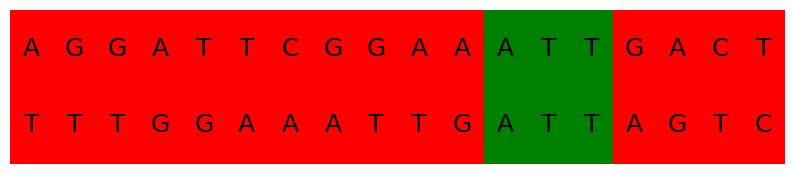

ATGCCTATTATAATAGGA
CCAATTATAATTGGTGGA
['Met', 'Pro', 'Ile', 'Ile', 'Ile', 'Gly']
['Pro', 'Ile', 'Ile', 'Ile', 'Gly', 'Gly']


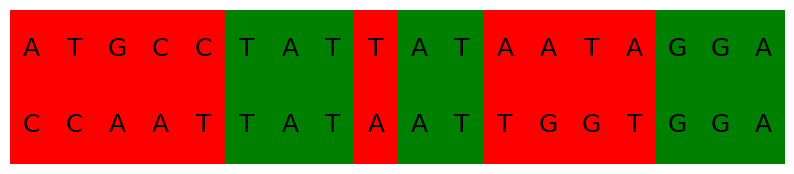

TCATATAGGAACTTCAGT
CATTCTAGTGCATCTGTA
['Ser', 'Tyr', 'Arg', 'Asn', 'Phe', 'Ser']
['His', 'Ser', 'Ser', 'Ala', 'Ser', 'Val']


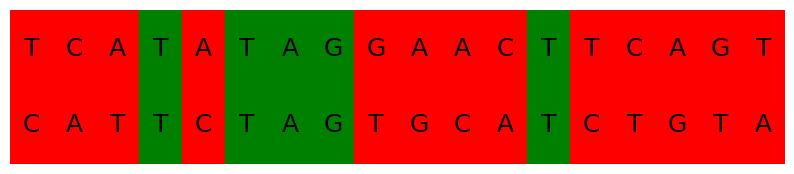

ATGATCAGTGGGTATTAC
TGGTCAGTAATTATTACT
['Met', 'Ile', 'Ser', 'Gly', 'Tyr', 'Tyr']
['Trp', 'Ser', 'Val', 'Ile', 'Ile', 'Thr']


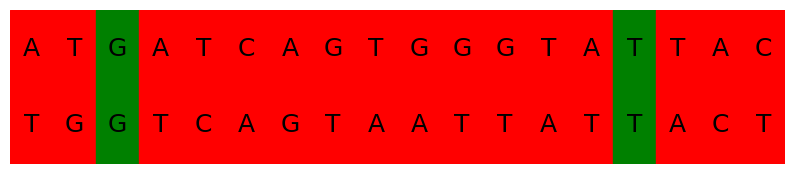

GTAAATTTCATTACTACT
ATTAATTTTATTACTACT
['Val', 'Asn', 'Phe', 'Ile', 'Thr', 'Thr']
['Ile', 'Asn', 'Phe', 'Ile', 'Thr', 'Thr']


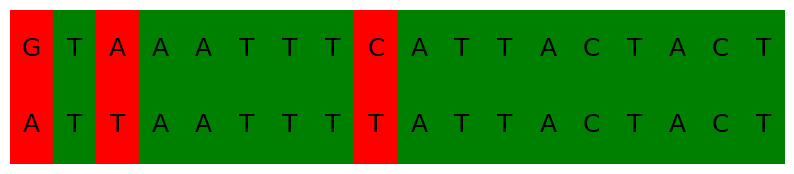

CAATTATTAATATACGCT
ATAATTAATATACAAATT
['Gln', 'Leu', 'Leu', 'Ile', 'Tyr', 'Ala']
['Ile', 'Ile', 'Asn', 'Ile', 'Gln', 'Ile']


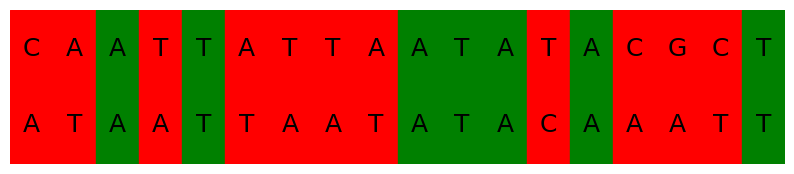

GGAACATCATTAAGAATA
GGAACATCTTTAAGATTA
['Gly', 'Thr', 'Ser', 'Leu', 'Arg', 'Ile']
['Gly', 'Thr', 'Ser', 'Leu', 'Arg', 'Leu']


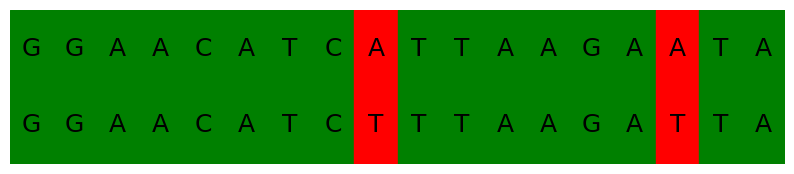

GTTTGATAAAATACCTCT
AATAAAATTAAATTTGAT
['Val', 'Stop', 'Stop', 'Asn', 'Thr', 'Ser']
['Asn', 'Lys', 'Ile', 'Lys', 'Phe', 'Asp']


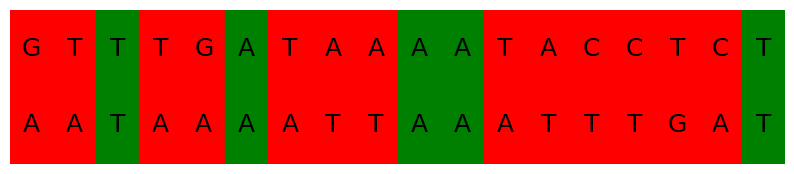

TTTAGCTTCTAATTTAGC
TTATCTTCTTCTATTGCA
['Phe', 'Ser', 'Phe', 'Stop', 'Phe', 'Ser']
['Leu', 'Ser', 'Ser', 'Ser', 'Ile', 'Ala']


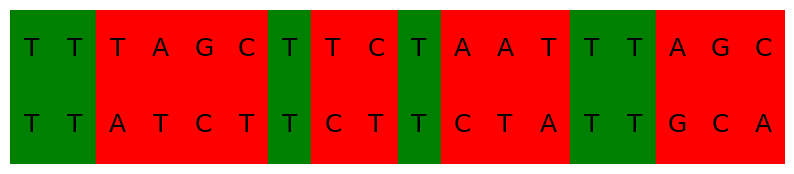

ATAATCATTCGCCTAGAA
TTAATTCGATTTGAATTA
['Ile', 'Ile', 'Ile', 'Arg', 'Leu', 'Glu']
['Leu', 'Ile', 'Arg', 'Phe', 'Glu', 'Leu']


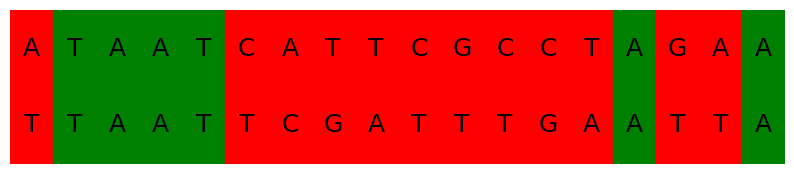

In [99]:
# 2
# 3
for i in range(PROTOTYPE_COUNT):
    string = decode_onehot(input_tensor[0].numpy(), three_dim=True)

    # print(string[best_prototypes[9][i]*18:(best_prototypes[9][i]+1)*18])
    # print("")

    # Draw 18 squares each with one character of prot using matplotlib
    prot = prot_strings[8][int(best_prototypes[8][i])]
    corresponding = string[best_prototypes[8][i]*18:(best_prototypes[8][i]+1)*18]

    # This only works since prototypes are length 0 mod 3
    prot_amino = create_amino(prot)
    string_amino = create_amino(corresponding)
    print(prot_amino)
    print(string_amino)

    for i, c in enumerate(prot):
        plt.text(.05 * i+.05, 0.5, c, fontsize=18, ha='center', va='center')
        plt.text(.05 * i+.05, 0.4, corresponding[i], fontsize=18, ha='center', va='center')
        # Color the squares based on whether the character matches the prototype
        if c == corresponding[i]:
            plt.gca().add_patch(plt.Rectangle((.05 * i+.025, 0.35), .05, .2, fill=True, color='green'))
        else:
            plt.gca().add_patch(plt.Rectangle((.05 * i+.025, 0.35), .05, .2, fill=True, color='red'))

    # Resize plot image
    plt.gcf().set_size_inches(10, 2)
    plt.ylim(.35, .55)
    plt.xlim(.025, .925)

    # Hide plot axis
    plt.axis('off')
    plt.show()

In [76]:
is_best_prototype_location = torch.zeros(40, 40*18)

for i in range(40):
    best_prototypes_for_class = best_prototypes[i]

    for ind, j in enumerate(best_prototypes_for_class):
        # is_best_prototype_location[i][j*18:(j+1)*18] = (10 - ind) / 10
        is_best_prototype_location[i][j*18:(j+1)*18] = 1

Phoridae
Cecidomyiidae


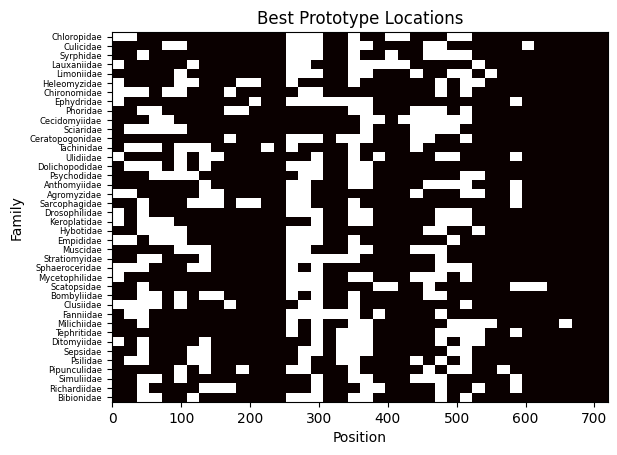

In [77]:
# Draw the heatmap
import matplotlib.pyplot as plt

classes = train_dataset.get_classes(TAXONOMY_NAME)[0]

plt.imshow(is_best_prototype_location, cmap='hot', interpolation='nearest')
plt.title("Best Prototype Locations")
plt.ylabel("Family")
plt.xlabel("Position")

# Set the y axis labels to the class names, make them diagonal
plt.yticks(range(40), classes)
# Decrease the y axis label font size
plt.yticks(fontsize=6)

# Make its aspect ratio 1:1
plt.gca().set_aspect('auto', adjustable='box')

print(classes[8])
print(classes[input_tensor[1]])